In [ ]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/content/acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2008-03-28,43.640,43.6400,43.640,43.640,231,0
2008-03-31,43.553,43.5530,42.964,42.964,459,0
2008-04-01,43.772,44.1210,43.694,44.121,670,0
2008-04-02,48.528,48.5280,44.468,44.608,12281,0
2008-04-03,52.004,52.0040,44.382,44.860,33307,0
...,...,...,...,...,...,...
2017-11-06,70.570,70.8150,70.540,70.790,764087,0
2017-11-07,70.730,70.8501,70.600,70.700,1731062,0
2017-11-08,70.710,70.8700,70.610,70.840,536922,0


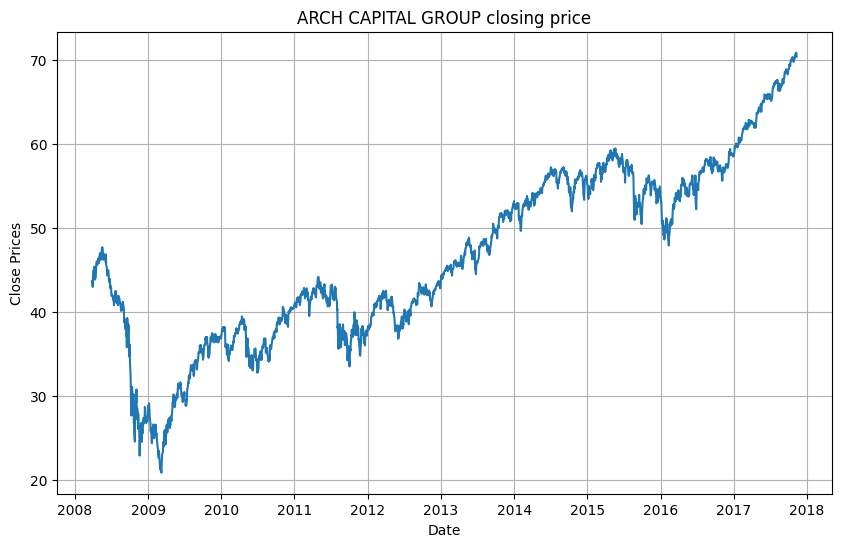

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

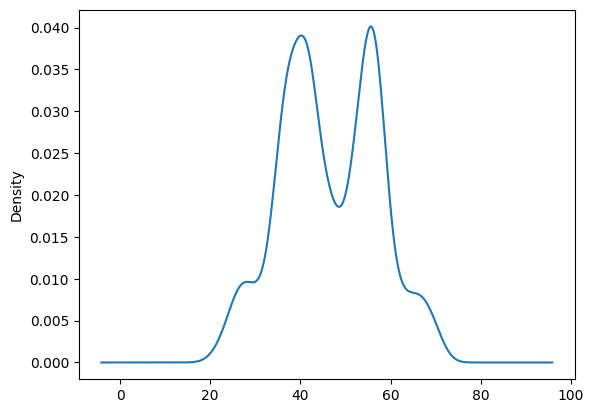

In [ ]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

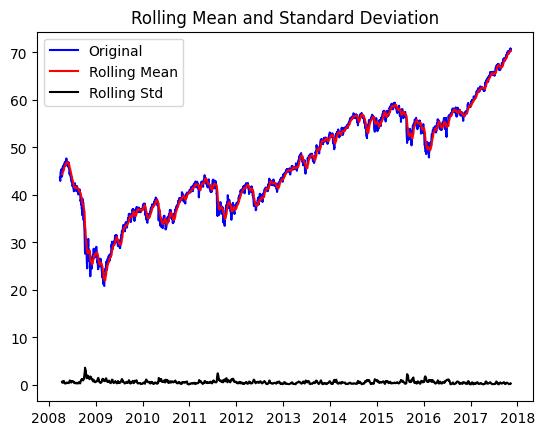

Results of dickey fuller test
Test Statistics                   0.138175
p-value                           0.968573
No. of lags used                 20.000000
Number of observations used    2404.000000
critical value (1%)              -3.433073
critical value (5%)              -2.862743
critical value (10%)             -2.567410
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

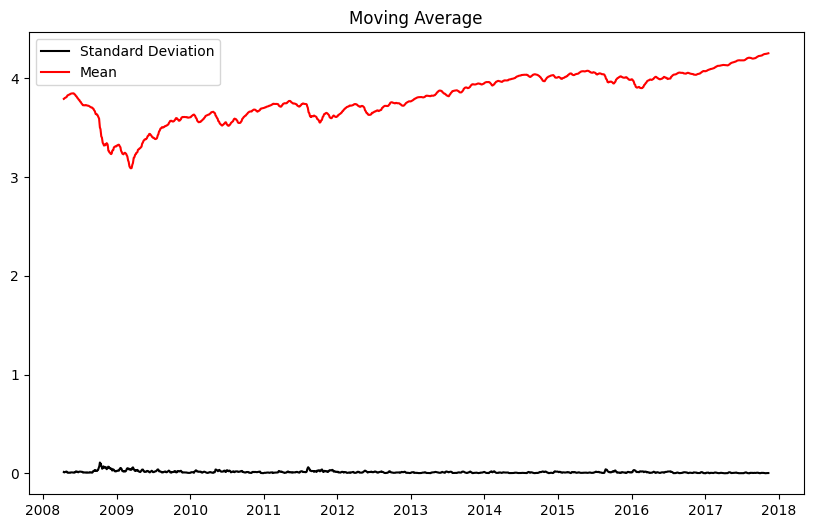

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


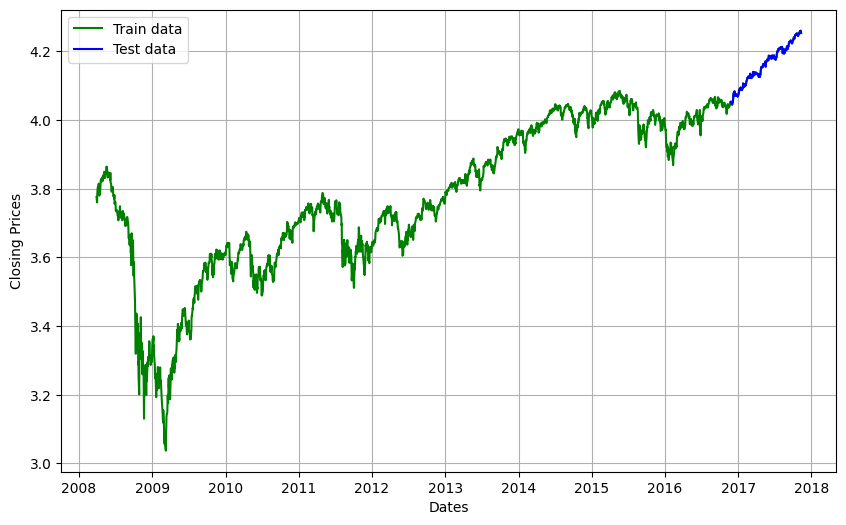

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11978.913, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12269.677, Time=1.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=3.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12263.210, Time=2.48 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6107.582, Time=0.75 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.76 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-12275.616, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3127.862, Time=1.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-12273.630, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-12277.391, Time=0.77 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5345.093

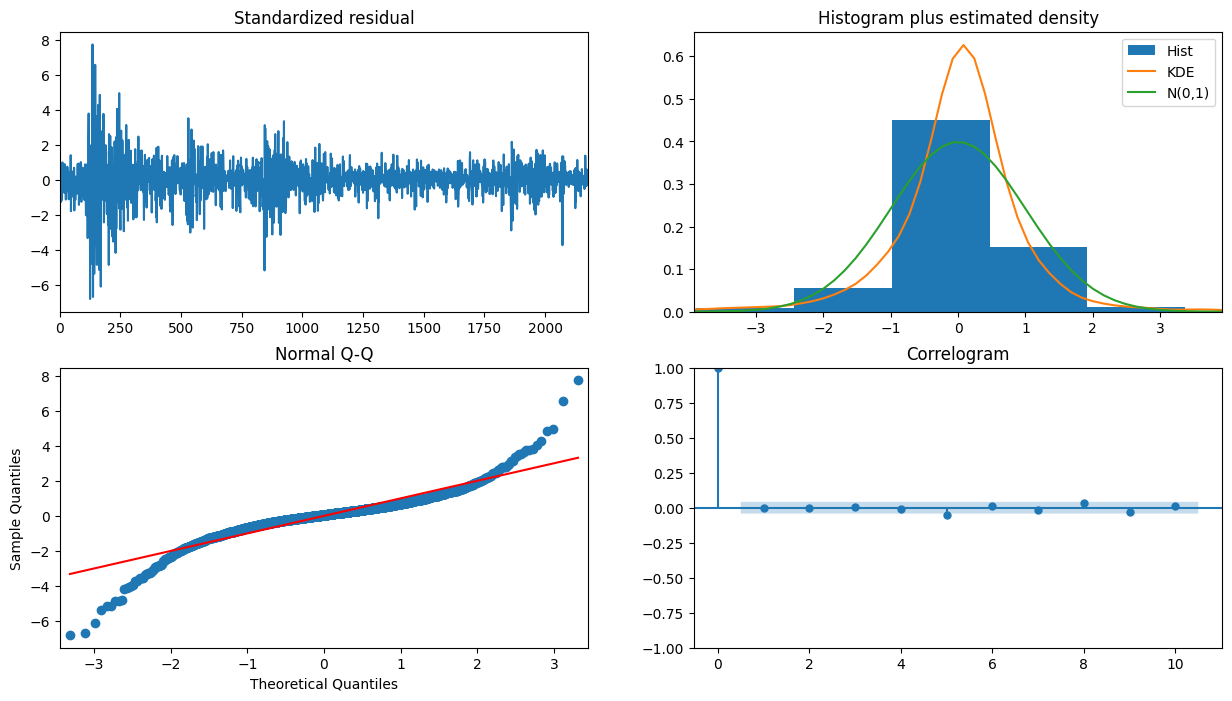

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Modeling

# Build Model
import statsmodels
model = statsmodels.tsa.arima.model.ARIMA(train_data, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2179
Model:                 ARIMA(1, 1, 2)   Log Likelihood                6142.561
Date:                Mon, 15 Jan 2024   AIC                         -12277.122
Time:                        14:25:32   BIC                         -12254.378
Sample:                             0   HQIC                        -12268.807
                               - 2179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0840      0.270      0.311      0.756      -0.445       0.613
ma.L1         -0.1586      0.268     -0.591      0.554      -0.684       0.367
ma.L2         -0.0357      0.024     -1.491      0.1

In [ ]:
# Forecast
fc= fitted.forecast(321, alpha=0.05)  # 95% conf
# print(fc,se,conf)
# # Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data, label='training data')
# plt.plot(test_data, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.10)
# plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('ARCH CAPITAL GROUP Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()
print(fc.shape)
print(test_data.shape)

(321,)
(243,)


In [ ]:
# # report performance
# mse = mean_squared_error(test_data[1], fc[1])
# print('MSE: '+str(mse))
# mae = mean_absolute_error(test_data, fc)
# print('MAE: '+str(mae))
# rmse = math.sqrt(mean_squared_error(test_data, fc))
# print('RMSE: '+str(rmse))
# mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
# print('MAPE: '+str(mape))


KeyError: 1